In [1]:
# install and import libraries
%%capture
!pip install ir_datasets
!pip install demoji

import re
import html
import string
import datetime as dt

import numpy as np
import pandas as pd
import ir_datasets
import demoji

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet as wn


from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from collections import Counter

pd.set_option('max_colwidth', 800)

In [2]:
# load dataset
dataset = ir_datasets.load("cord19/trec-covid")
print(f"queries: {dataset.queries_count()}, docs: {dataset.docs_count()}, qrels: {dataset.qrels_count()}")

queries: 50, docs: 192509, qrels: 69318


# Part 1: Analysis of Queries and Documents

In [3]:
%%capture
# convert the collection in a dataframe
queries = pd.DataFrame(dataset.queries_iter())
docs = pd.DataFrame(dataset.docs_iter())
qrels = pd.DataFrame(dataset.qrels_iter())

docs['date'] = pd.to_datetime(docs['date'])

In [4]:
display(queries.sample(5))
display(docs.sample(5))
display(qrels.sample(5))

,query_id,title,description,narrative
24,25,coronavirus biomarkers,which biomarkers predict the severe clinical course of 2019-nCOV infection?,"Looking for information on biomarkers that predict disease outcomes in people infected with coronavirus, specifically those that predict severe and fatal outcomes."
7,8,coronavirus under reporting,how has lack of testing availability led to underreporting of true incidence of Covid-19?,Looking for studies answering questions of impact of lack of complete testing for Covid-19 on incidence and prevalence of Covid-19.
3,4,how do people die from the coronavirus,what causes death from Covid-19?,Studies looking at mechanisms of death from Covid-19.
34,35,coronavirus public datasets,What new public datasets are available related to COVID-19?,"Seeking articles that specifically release new data related to SARS-CoV-2 or COVID-19, including genomic data, patient data, public health data, etc. Articles that reference previously existing datasets are not relevant."
43,44,impact of masks on coronavirus transmission,How much impact do masks have on preventing the spread of the COVID-19?,"Looking for studies of how masks slow SARS-CoV-2 transmission, including impact on R0. Studies can include both lab and population studies."


,doc_id,title,doi,date,abstract
175710,28mi8go0,H7N9 influenza-the laboratory presentations: A letter to editor,10.1016/s2221-1691(13)60118-5,2013-07-01,
159309,1is0rv6c,Pulmonary cytomegalovirus (CMV) DNA shedding in allogeneic hematopoietic stem cell transplant recipients: Implications for the diagnosis of CMV pneumonia,10.1016/j.jinf.2019.02.009,2019-05-31,"Summary Objectives To date no definitive cut-off value for cytomegalovirus (CMV) DNA load in bronchoalveolar lavage (BAL) fluid specimens has been established to discriminate between CMV pneumonia and pulmonary CMV DNA shedding in allogeneic hematopoietic stem cell transplant (allo-HSCT) recipients. Methods The current retrospective study is aimed at assessing the range of CMV DNA loads quantified in BAL fluid specimens from allo-HSCT patients with pneumonia in which different microorganisms were causally involved. Results A total of 144 BAL specimens from 123 patients were included. CMV DNA was detected in 56 out of 144 BAL fluid specimens and the median CMV DNA load from patients in whom CMV pneumonia was unlikely or could be tentatively ruled out was 1210 (31–68, 920) IU/ml. The fre..."
44216,pqtzdhml,Letter to the Editor: Addressing test security issues pertaining to reuse of closed-book summative assessment items possibly compromised during the COVID-19 pandemic.,10.1152/advan.00096.2020,2020-09-01,
115243,a3j0045a,Blueprint for a pop-up SARS-CoV-2 testing lab,,2020-01-01,
139097,7y9el2n1,Ultraviolet radiation for flavonoid augmentation in Isatis tinctoria L. hairy root cultures mediated by oxidative stress and biosynthetic gene expression,10.1016/j.indcrop.2018.03.046,2018-08-31,"Abstract Search of cost-effective strategies that can enhance the accumulation of phytochemicals of pharmaceutical interest in plant in vitro cultures is an essential task. For the first time, Isatis tinctoria L. hairy root cultures were exposed to ultraviolet radiation (ultraviolet-A, ultraviolet-B, and ultraviolet-C) in an attempt to promote the production of pharmacologically active flavonoids. Results showed that the maximum flavonoid accumulation (7259.12 ± 198.19 μg/g DW) in I. tinctoria hairy root cultures treated by 108 kJ/m2 dose of UV-B radiation increased 16.51-fold as compared with that in control (439.68 ± 8.27 μg/g DW). Additionally, antioxidant activity enhancement and cell wall reinforcement were found in the treated I. tinctoria hairy root cultures, indicating the posi..."


,query_id,doc_id,relevance,iteration
2876,2,ym7ce5ux,0,3
16526,11,drtviivx,0,1
62811,44,aprunfqx,1,5
2698,2,t624zyyc,0,1
63109,44,jj2fywhh,0,5


* numbers
* punctuation
* symbols
* whitespaces
* stop words
* HTML tags
* repeated characters
* URLs
* emojis

---

- stemming / lemmatization ?

## Preprocessing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  


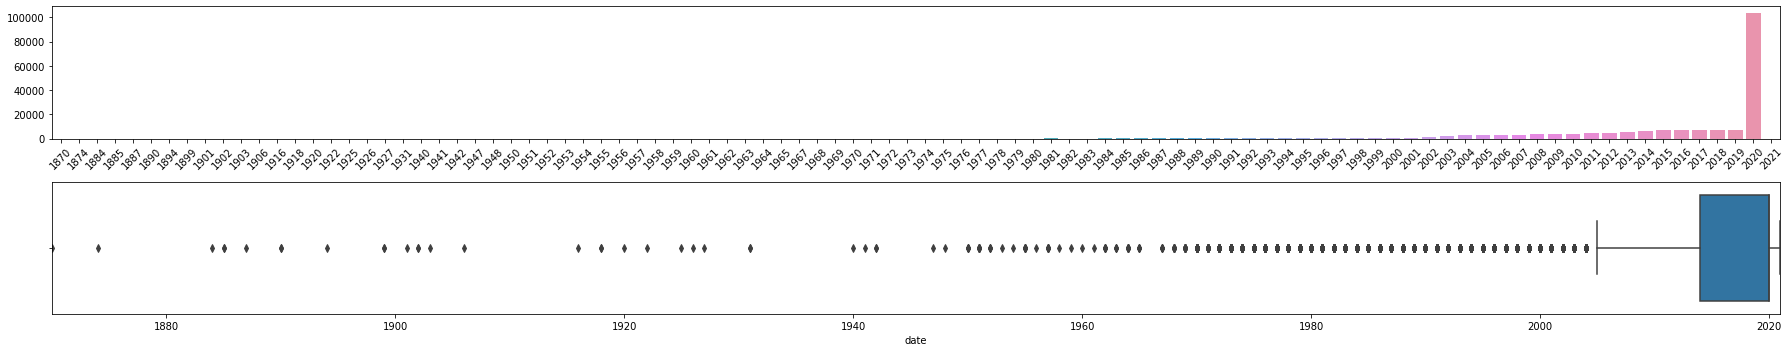

In [5]:
years = docs["date"].dt.year
years.dropna(inplace=True)
years = years.astype(int)

u_years, u_counts = np.unique(years, return_counts=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 5))

sns.barplot(x=u_years, y=u_counts, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)

sns.boxplot(x=years, ax=ax2, orient="h")
ax2.margins(0)

fig.tight_layout()

In [6]:
emojis = set()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  e1 = demoji.findall(row["title"])
  if e1:
    for e in list(e1.keys()):
      emojis.add(e)
    # print(index, e1)

  e2 = demoji.findall(row["abstract"])
  if e2:
    for e in list(e2.keys()):
      emojis.add(e)
    # print(index, e2)

  0%|          | 0/192509 [00:00<?, ?it/s]

In [7]:
emojis

{'©', '®', '™', '▪', '▶', '♀', '♂', '♦', '⬇'}

In [8]:
docs["abstract"][70663]

'Coronavirus EndoU inhibits dsRNA-activated antiviral responses; however, the physiologic RNA substrates of EndoU are unknown. In this study, we used mouse hepatitis virus (MHV)-infected bone-marrow-derived macrophage (BMM) and cyclic phosphate cDNA sequencing to identify the RNA targets of EndoU. EndoU targeted viral RNA, cleaving the 3′ side of pyrimidines with a strong preference for U⬇A and C⬇A sequences (endoY⬇A). EndoU-dependent cleavage was detected in every region of MHV RNA, from the 5′ NTR to the 3′ NTR, including transcriptional regulatory sequences (TRS). Cleavage at two CA dinucleotides immediately adjacent to the MHV poly(A) tail suggest a mechanism to suppress negative-strand RNA synthesis and the accumulation of viral dsRNA. MHV with EndoU (EndoUmut) or 2′-5′ phosphodiesterase (PDEmut) mutations provoked the activation of RNase L in BMM, with corresponding cleavage of RNAs by RNase L. The physiologic targets of EndoU are viral RNA templates required for negative-strand 

In [9]:
keywords = ["covid 19", "covid-19", "covid19", "sars-cov-2", "sarscov2", 
            "sars cov 2", "2019-nCoV", "Wuhan virus", "Chinese flu",
            "COronaVIrusDisease"]

keep = set()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  text = " ".join([row["title"], row["abstract"]])
  if any(re.findall(r'|'.join(keywords), text, re.IGNORECASE)):
    keep.add(index)

  # the few documents without date contain at least one keyword
  if row["date"] and row["date"] is not pd.NaT:
    if row["date"].year >= 2019:         
        if any(re.findall(r'coronavirus', " ".join([row["title"], row["abstract"]]), re.IGNORECASE)):
          keep.add(index)

print(f"{len(keep)}, {round(len(keep) / len(docs) * 100)}%")

docs = docs.iloc[list(keep)]

  0%|          | 0/192509 [00:00<?, ?it/s]

84048, 44%


In [10]:
def remove_urls(text):
    regex = "(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
    return re.sub(regex, '', text)

def remove_doi(text):
    regex = r"\b(doi:\s+)?(10[.][0-9]{4,}(?:[.][0-9]+)*(?:(?![\"&\'<>])\S)+)\b"
    return re.sub(regex, "", text)

# decidere se tenere qualche carattere
def remove_punctuation(text):
    punctuation = string.punctuation + '“”'
    return "".join([i for i in text if i not in punctuation])

def remove_extra_whitespace(text):
    return " ".join(text.split())

def replace_html_entities(text):
    return html.unescape(text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

def remove_emojis(text):
    return demoji.replace(text)

def remove_numbers(text):
    pass


# il lemmatizer di wordnet ha solo questi 4 tag 
def pos2wordnet(nltk_pos):
  if nltk_pos.startswith('J'):
    return wn.ADJ
  elif nltk_pos.startswith('V'):
    return wn.VERB
  elif nltk_pos.startswith('N'):
    return wn.NOUN
  elif nltk_pos.startswith('R'):
    return wn.ADV
  else:
    return wn.NOUN


def preprocess(text):
  sentences = nltk.sent_tokenize(text)
  
  tokens_list = []
  for sent in sentences:
    sent = sent.lower()
    sent = remove_urls(sent)
    sent = remove_doi(sent)
    sent = remove_extra_whitespace(sent)
    sent = replace_html_entities(sent) # before removing punctuation (&\w+;)
    sent = remove_emojis(sent)
    sent = remove_punctuation(sent)
    sent = remove_stopwords(sent)

    tokens = nltk.word_tokenize(sent)
    tokens_list.append(tokens)

  tagged_tokens = nltk.pos_tag_sents(tokens_list)

  wnl = WordNetLemmatizer()

  result = []
  for tokens in tagged_tokens:
    for (token, pos) in tokens:
      t = wnl.lemmatize(token, pos2wordnet(pos))
      result.append(t)
    
  return result

In [98]:
text = docs["title"][4582]
x = preprocess(text)
text, x

('Therapeutic strategies in an outbreak scenario to treat the novel coronavirus originating in Wuhan, China',
 ['therapeutic',
  'strategy',
  'outbreak',
  'scenario',
  'treat',
  'novel',
  'coronavirus',
  'originate',
  'wuhan',
  'china'])

In [99]:
# global lists of tokens for wordclouds
titles = []
abstracts = []

docs_preprocessed = docs.copy()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  title_tokens = preprocess(row["title"])
  abstract_tokens = preprocess(row["abstract"])

  docs_preprocessed.loc[index, "title"] = ' '.join(title_tokens)
  docs_preprocessed.loc[index, "abstract"] = ' '.join(abstract_tokens)

  titles.extend(title_tokens)
  abstracts.extend(abstract_tokens)

  0%|          | 0/84048 [00:00<?, ?it/s]

In [ ]:
np.save("data/docs_processed", docs_preprocessed)

## Word Cloud

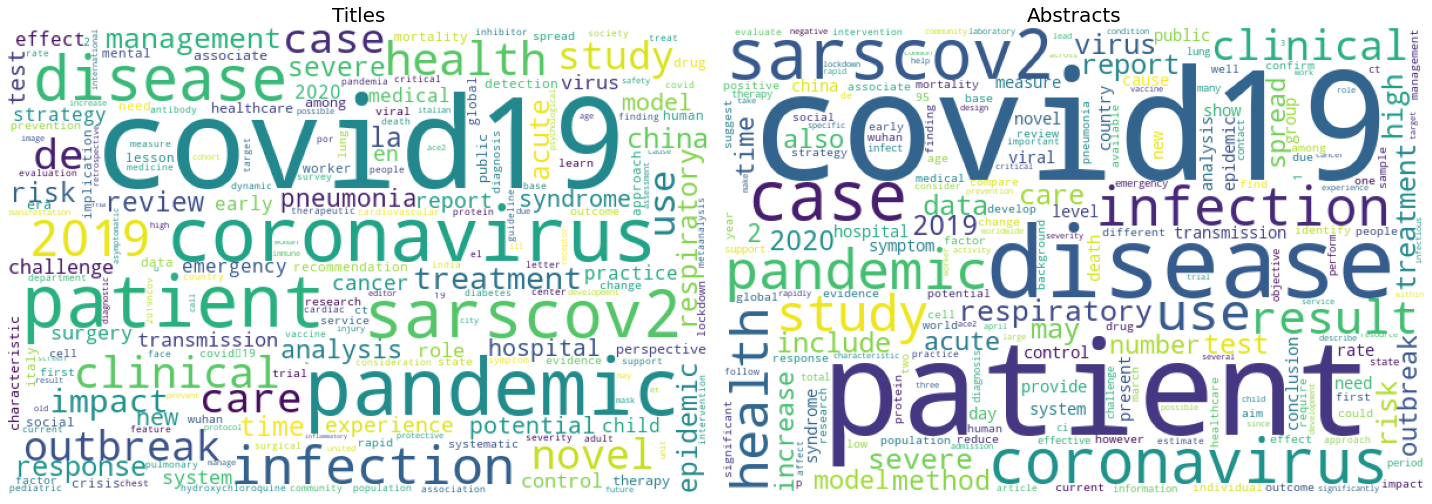

In [101]:
counter_title = Counter(titles)
counter_abstract = Counter(abstracts)

wc1 = WordCloud(collocations=False, background_color="white", width=600, height=400)
wc2 = WordCloud(collocations=False, background_color="white", width=600, height=400)

wc_titles = wc1.fit_words(counter_title)
wc_abstracts = wc2.fit_words(counter_abstract)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.imshow(wc_titles)
ax1.set_title("Titles", fontsize=20)
ax1.axis("off")

ax2.imshow(wc_abstracts)
ax2.set_title("Abstracts", fontsize=20)
ax2.axis("off")

fig.tight_layout()

## Token Statistics

In [102]:
print("\n[Number of Tokens]")
print("Titles:", len(counter_title.keys()))
print("Abstracts:", len(counter_abstract.keys()))

k = 10
top_k_titles = [word for word, count in counter_title.most_common(k)]
top_k_abstracts = [word for word, count in counter_abstract.most_common(k)]

print(f"\n[Top {k} Most Common Tokens]")
print(f"Titles: {', '.join(top_k_titles)}")
print(f"Abstracts: {', '.join(top_k_abstracts)}")


[Number of Tokens]
Titles: 29896
Abstracts: 116349

[Top 10 Most Common Tokens]
Titles: covid19, pandemic, coronavirus, patient, sarscov2, disease, infection, 2019, health, clinical
Abstracts: covid19, patient, disease, sarscov2, case, coronavirus, pandemic, infection, use, study


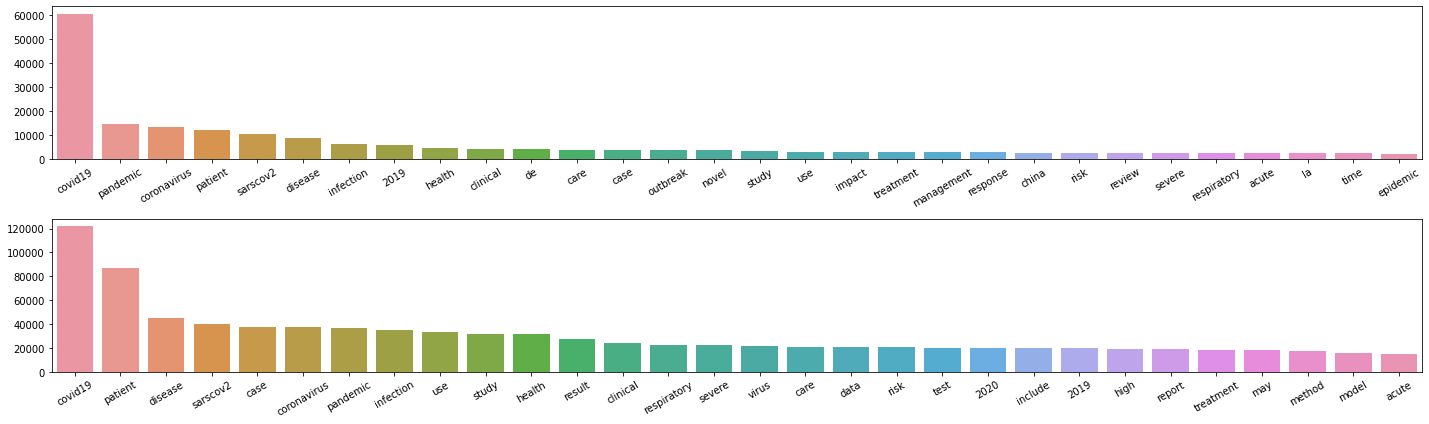

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 30

common_titles = dict(counter_title.most_common(k))
x_title = list(common_titles.keys())
y_title = list(common_titles.values())

common_abstracts = dict(counter_abstract.most_common(k))
x_abstract = list(common_abstracts.keys())
y_abstract = list(common_abstracts.values())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
sns.barplot(x=x_title, y=y_title, ax=ax1)
sns.barplot(x=x_abstract, y=y_abstract, ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 30)
fig.tight_layout()

# Part 2: Basic Search

## Preprocessing of the query
Eliminate stopwords, remove punctuation. 
You can also perform any other pre-processing step.


* Lowcase
* Remove punctuation
* Remove extra whitespaces
* Normalize covid words
* Stop words
* Lemmatization
* Remove HTML tags
* Remove URLs
* Remove emojis



In [104]:
def covid_norm(text):
  keywords = ["covid 19", "covid-19","sars-cov-2", "sarscov2", 
            "sars cov 2", "2019-nCoV", "Wuhan virus", "Chinese flu",
            "COronaVIrusDisease"]
            
  for key in keywords:
    text = text.replace(key, 'covid19')

  return text

In [105]:
# decidere se tenere qualche carattere
def remove_punctuation_query(text):
    punctuation = string.punctuation
    punctuation = punctuation.replace('+', '')
    punctuation = punctuation.replace('-', '') 
    punctuation = punctuation.replace('"', '')
    punctuation = punctuation.replace('{', '')
    punctuation = punctuation.replace('}', '')
    punctuation = punctuation.replace('(', '')
    punctuation = punctuation.replace(')', '')
    punctuation = punctuation.replace('.', '')
    punctuation = punctuation.replace(':', '')
    punctuation = punctuation.replace('~', '')
    punctuation = punctuation.replace('^', '')
    #print(punctuation)
    text = "".join([i for i in text if i not in punctuation])
    return text

In [106]:
def preprocessing_query(text, lower=True, URLs_remove=True, doi_remove=True, 
                        extra_whitespace_remove=True,
                        covid_normalization=True, html_remove=True, 
                        emoji_remove=True, punctuation_remove=True,
                        stop_words=True, lemmatization=True ):
  
  sentences = nltk.sent_tokenize(text)
  
  tokens_list = []
  for sent in sentences:
    if lower:
      sent = sent.lower()
    if URLs_remove:
      sent = remove_urls(sent)
    if doi_remove:
      sent = remove_doi(sent)
    if extra_whitespace_remove:
      sent = remove_extra_whitespace(sent)
    if covid_normalization:
      sent = covid_norm(sent)
    if html_remove:
      sent = replace_html_entities(sent) # before removing punctuation (&\w+;)
    if emoji_remove:
      sent = remove_emojis(sent)
    if punctuation_remove:
      sent = remove_punctuation_query(sent)
    if stop_words:
      sent = remove_stopwords(sent)

    tokens = nltk.word_tokenize(sent)
    tokens_list.append(tokens)

  tagged_tokens = nltk.pos_tag_sents(tokens_list)

  wnl = WordNetLemmatizer()

  result = []
  for tokens in tagged_tokens:
    for (token, pos) in tokens:
      if lemmatization:
        t = wnl.lemmatize(token, pos2wordnet(pos))
      else:
        t = token
      if t == 'covid':
        t = 'covid19'
      result.append(t)

  text = ' '.join(result)
  text = text.replace("``", '"')
  text = text.replace("''", '"')

  return text

In [107]:
test_query = [ 'CoVid', 'covid    19', 'covid-19  influenza', 'covid, influenza', 'a covid flue is going on',
               '-term1 +term2', '{term1 term2}', 'term1^2.3', 'title:term1',
               '+title:term1', 'title:(term1 term2)^2.3', 'term1 -title:term2', 
               '"term1 term2"', '+"term1 term2"', '"term1 term2"~n']

check_query = ['covid19', 'covid19', 'covid19 influenza', 'covid19 influenza', 'covid19 flue go', 
               '-term1 +term2', '{ term1 term2 }', 'term1^2.3', 'title : term1', 
               '+title : term1', 'title : ( term1 term2 ) ^2.3', 'term1 -title : term2', 
               '" term1 term2 "', '+ " term1 term2 "', '" term1 term2 " ~n']

In [108]:
preprocessed_query = []
for query in test_query:
  preprocessed_query.append( preprocessing_query(query, lemmatization=True) )
print( preprocessed_query )

['covid19', 'covid19', 'covid19 influenza', 'covid19 influenza', 'covid19 flue go', '-term1 +term2', '{ term1 term2 }', 'term1^2.3', 'title : term1', '+title : term1', 'title : ( term1 term2 ) ^2.3', 'term1 -title : term2', '" term1 term2 "', '+ " term1 term2 "', '" term1 term2 " ~n']


In [109]:
  assert check_query == preprocessed_query

## Index the documents

Use PyTerrier to index the documents.

You can choose freely the indexing configurations.
You can index either the document’s titles, abstract, or both.

### Libraries

In [110]:
!pip install python-terrier

In [111]:
import pyterrier as pt

### Data

In [112]:
print( type(docs_preprocessed) )
docs_df = pd.DataFrame(docs_preprocessed, columns = ['id','title','doi','date', 'abstract'])
print( type( docs_df ))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [113]:
print("The dataset has the type {} for the column ID" .format( type( docs_df.iloc[0,0] )) )
print("The dataset has the type {} for the column TITLE" .format( type( docs_df.iloc[0,1] )) )
print("The dataset has the type {} for the column DATE" .format( type( docs_df.iloc[0,2] )) )
print("The dataset has the type {} for the column ABSTRACT" .format( type( docs_df.iloc[0,3] )) )
print("The dataset has the type {} for the column DOI" .format( type( docs_df.iloc[0,4] )) )

The dataset has the type <class 'numpy.float64'> for the column ID
The dataset has the type <class 'str'> for the column TITLE
The dataset has the type <class 'str'> for the column DATE
The dataset has the type <class 'pandas._libs.tslibs.timestamps.Timestamp'> for the column ABSTRACT
The dataset has the type <class 'str'> for the column DOI


In [114]:
print("The dataset has {} rows of ID empty" .format(len( docs_df[docs_df['id'] == '' ] )) )
print("The dataset has {} rows of TITLE empty" .format(len( docs_df[docs_df['title'] == '' ] )) )
print("The dataset has {} rows of DATE empty" .format(len( docs_df[docs_df['date'].isnull() ] )) )
print("The dataset has {} rows of ABSTRACT empty" .format(len( docs_df[docs_df['abstract'] == '' ] )) )
print("The dataset has {} rows of DOI empty" .format(len( docs_df[docs_df['doi'] == '' ] )) )

The dataset has 0 rows of ID empty
The dataset has 8 rows of TITLE empty
The dataset has 17 rows of DATE empty
The dataset has 34043 rows of ABSTRACT empty
The dataset has 40903 rows of DOI empty


In [115]:
docs_df["title"].replace({"": "Vuoto"}, inplace=True)
docs_df["abstract"].replace({"": "Vuoto"}, inplace=True)
docs_df["doi"].replace({"": "Vuoto"}, inplace=True)
docs_df["date"].fillna( pd.Timestamp(0, unit='s'), inplace = True)

In [116]:
print("The dataset has {} rows of ID empty" .format(len( docs_df[docs_df['id'] == '' ] )) )
print("The dataset has {} rows of TITLE empty" .format(len( docs_df[docs_df['title'] == '' ] )) )
print("The dataset has {} rows of DATE empty" .format(len( docs_df[docs_df['date'].isnull() ] )) )
print("The dataset has {} rows of ABSTRACT empty" .format(len( docs_df[docs_df['abstract'] == '' ] )) )
print("The dataset has {} rows of DOI empty" .format(len( docs_df[docs_df['doi'] == '' ] )) )

The dataset has 0 rows of ID empty
The dataset has 0 rows of TITLE empty
The dataset has 0 rows of DATE empty
The dataset has 0 rows of ABSTRACT empty
The dataset has 0 rows of DOI empty


In [117]:
np.where( pd.isnull(docs_df) )

(array([    0,     1,     2, ..., 84045, 84046, 84047]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [118]:
num_id = [str(i) for i in range(1, len(docs_df.index)+1)]
#print(num_id)
docs_df.insert(0, "docno", num_id, True)

### Index

In [119]:
if not pt.started():
  pt.init()

In [120]:
# index the text, record the docnos as metadata
pd_indexer = pt.DFIndexer("./pd_index", remove_stopwords=False,  overwrite=True)
index_ref = pd_indexer.index(docs_df['title'], docs_df['docno'])

18:40:22.113 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (64215) - further warnings are suppressed
18:40:32.784 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 6 empty documents


In [121]:
!ls -lh pd_index/

total 9.8M
-rw-r--r-- 1 root root 1.3M Jan 11 18:40 data.direct.bf
-rw-r--r-- 1 root root 1.4M Jan 11 18:40 data.document.fsarrayfile
-rw-r--r-- 1 root root 1.2M Jan 11 18:40 data.inverted.bf
-rw-r--r-- 1 root root 2.0M Jan 11 18:40 data.lexicon.fsomapfile
-rw-r--r-- 1 root root 1017 Jan 11 18:40 data.lexicon.fsomaphash
-rw-r--r-- 1 root root  93K Jan 11 18:40 data.lexicon.fsomapid
-rw-r--r-- 1 root root 1.7M Jan 11 18:40 data.meta-0.fsomapfile
-rw-r--r-- 1 root root 657K Jan 11 18:40 data.meta.idx
-rw-r--r-- 1 root root 1.7M Jan 11 18:40 data.meta.zdata
-rw-r--r-- 1 root root 4.1K Jan 11 18:40 data.properties


In [122]:
index = pt.IndexFactory.of(index_ref)

In [123]:
print(index.getCollectionStatistics().toString())

i = 0
max = 10
for kv in index.getLexicon():
  i = i+1
  if i < max:
    print("%s -> %s" % (kv.getKey(), kv.getValue().toString()) ) 
  if i == max:
    print(".....")
    break

Number of documents: 84048
Number of terms: 23780
Number of postings: 730926
Number of fields: 0
Number of tokens: 755244
Field names: []
Positions:   false

0 -> term19327 Nt=5 TF=5 maxTF=1 @{0 0 0}
000 -> term3877 Nt=27 TF=27 maxTF=1 @{0 11 6}
002 -> term9283 Nt=4 TF=4 maxTF=1 @{0 75 0}
016 -> term9987 Nt=1 TF=1 maxTF=1 @{0 86 2}
019 -> term11919 Nt=1 TF=1 maxTF=1 @{0 89 6}
025 -> term17931 Nt=2 TF=2 maxTF=1 @{0 93 2}
03 -> term1335 Nt=4 TF=4 maxTF=1 @{0 101 0}
0354 -> term23230 Nt=1 TF=1 maxTF=1 @{0 110 4}
05 -> term1342 Nt=4 TF=4 maxTF=1 @{0 114 6}
.....


In [124]:
def index_model(index, model="TF_IDF"):
  list_model = ["TF_IDF", "PL2", "DLH", 
                "Hiemstra_LM", "Dirichlet_LM"]
  if model not in list_model:
    model = "TF_IDF"
  
  indexing_model = pt.BatchRetrieve(index, wmodel=model)
  return indexing_model

In [125]:
def search_in_model(query, model):
  query = preprocessing_query(query)
  return model.search(query)

In [126]:
tfidf = index_model(index, model="TF_IDF")

https://github.com/terrier-org/terrier-core/blob/5.x/doc/querylanguage.md

In [127]:
#A single query (that I manually provide) 
search_in_model("china", tfidf)

,qid,docid,docno,rank,score,query
0,1,31822,31823,0,3.959978,china
1,1,31823,31824,1,3.959978,china
2,1,75677,75678,2,3.959978,china
3,1,47911,47912,3,3.712163,china
4,1,76248,76249,4,3.712163,china
...,...,...,...,...,...,...
995,1,9671,9672,995,2.698815,china
996,1,9692,9693,996,2.698815,china
997,1,9992,9993,997,2.698815,china
998,1,10020,10021,998,2.698815,china


In [128]:
print("+woman covid")
retr = search_in_model("+woman covid", tfidf)
print( len(retr.index) )
display(retr.head(3))

print("+woman covid")
retr = tfidf.search("+woman covid")
print( len(retr.index) )
display(retr.head(3))

print("+woman +covid")
retr = search_in_model("+woman +covid", tfidf)
print( len(retr.index) )
display(retr.head(3))

print("+woman +covid")
retr = tfidf.search("+woman +covid")
print( len(retr.index) )
display(retr.head(3))

print("-woman +covid")
retr = search_in_model("-woman +covid", tfidf)
print( len(retr.index) )
display(retr.head(3))

print("-woman +covid")
retr = tfidf.search("-woman +covid")
print( len(retr.index) )
display(retr.head(3))

print('{woman covid}')
retr = search_in_model('{woman covid}', tfidf)
print( len(retr.index) )
display(retr.head(3))

print('{ woman term2 }')
retr = tfidf.search('{ woman covid }')
print( len(retr.index) )
display(retr.head(3))

+woman covid
620


,qid,docid,docno,rank,score,query
0,1,47855,47856,0,6.281295,+woman covid19
1,1,61994,61995,1,6.281295,+woman covid19
2,1,15788,15789,2,5.911363,+woman covid19


+woman covid
620


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489354,+woman covid
1,1,81751,81752,1,7.489354,+woman covid
2,1,68732,68733,2,6.807871,+woman covid


+woman +covid
15


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489354,+woman +covid
1,1,81751,81752,1,7.489354,+woman +covid
2,1,68732,68733,2,6.807871,+woman +covid


+woman +covid
15


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489354,+woman +covid
1,1,81751,81752,1,7.489354,+woman +covid
2,1,68732,68733,2,6.807871,+woman +covid


-woman +covid
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.315673,-woman +covid
1,1,2078,2079,1,4.315673,-woman +covid
2,1,3440,3441,2,4.315673,-woman +covid


-woman +covid
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.315673,-woman +covid
1,1,2078,2079,1,4.315673,-woman +covid
2,1,3440,3441,2,4.315673,-woman +covid


{woman covid}
1000


,qid,docid,docno,rank,score,query
0,1,48063,48064,0,1.224028,{ woman covid19 }
1,1,47855,47856,1,1.176884,{ woman covid19 }
2,1,61994,61995,2,1.176884,{ woman covid19 }


{ woman term2 }
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.01839,{ woman covid }
1,1,2078,2079,1,4.01839,{ woman covid }
2,1,3440,3441,2,4.01839,{ woman covid }


To do indexing just choose the model to use through the function:

`tfidf = index_model(index, model="TF_IDF")`

and then use the function:

`search_in_model("your query", tfidf)`


To know more about the query look [here](https://github.com/terrier-org/terrier-core/blob/5.x/doc/querylanguage.md)

To know more about the model you can use look [here](http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html). You can use model as "TF_IDF", "PL2", "DLH", "Hiemstra_LM", "Dirichlet_LM", etc.


# Part 3: Advanced Search (Optional)

# NOTE

prof: importate la precision. l'obiettivo é riportare la risposta migliore
